In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
teacher_model_training_data = pd.read_csv('Data/teacher_training_ab_wind.csv', encoding = "ISO-8859-1")

In [4]:
#teacher_model_testing_data = pd.read_csv('Data/teacher_test_ab_wind.csv', encoding = "ISO-8859-1")

In [5]:
#teacher_model_data = data.groupby('date').sample(frac=0.8, random_state = 123)

In [6]:
#teacher_model_data.to_csv('Data/teacher_ab_wind.csv', sep = ',', index = False)

In [7]:
#student_model_data = data[~data.index.isin(teacher_model_data.index)]

In [8]:
#student_model_data
#student_model_data.to_csv('Data/student_ab_wind.csv', sep = ',', index = False)

In [9]:
#teacher_model_training_data = teacher_model_data.groupby('date').sample(frac=0.7, random_state = 321)

In [10]:
#teacher_model_test_data = teacher_model_data[~teacher_model_data.index.isin(teacher_model_training_data.index)]

In [11]:
# teacher_model_training_data.to_csv('Data/teacher_training_ab_wind.csv', sep = ',', index = False)
# teacher_model_test_data.to_csv('Data/teacher_test_ab_wind.csv', sep = ',', index = False)

In [10]:
teacher_model_training_data['name'].unique() # 39 total

array(['ONEFOUR CDA', 'CAMROSE', 'MILK RIVER', 'SLAVE LAKE RCS',
       'LETHBRIDGE CDA', 'CORONATION CLIMATE', 'RED EARTH',
       'EDMONTON STONY PLAIN CS', 'VEGREVILLE', 'LACOMBE CDA 2',
       'FORT CHIPEWYAN RCS', 'CLARESHOLM', 'ROCKY MTN HOUSE (AUT)',
       'STRATHMORE AGDM', 'BROOKS', 'BANFF CS', 'MEDICINE HAT RCS',
       'JASPER WARDEN', 'SUNDRE A', 'FORT MCMURRAY CS',
       'PINCHER CREEK CLIMATE', 'BOW VALLEY', 'EDSON CLIMATE',
       'DRUMHELLER EAST', 'WHITECOURT', 'EDSON', 'MEDICINE HAT',
       'SLAVE LAKE', 'LLOYDMINSTER', 'HIGH LEVEL A', 'LETHBRIDGE',
       'FORT MCMURRAY A', 'FORT CHIPEWYAN', 'EDMONTON BLATCHFORD',
       "CALGARY INT'L CS", 'RED DEER REGIONAL A', 'HIGH LEVEL',
       'EDMONTON INTERNATIONAL CS', 'WHITECOURT A'], dtype=object)

Text(0.5, 0, 'Wind speed')

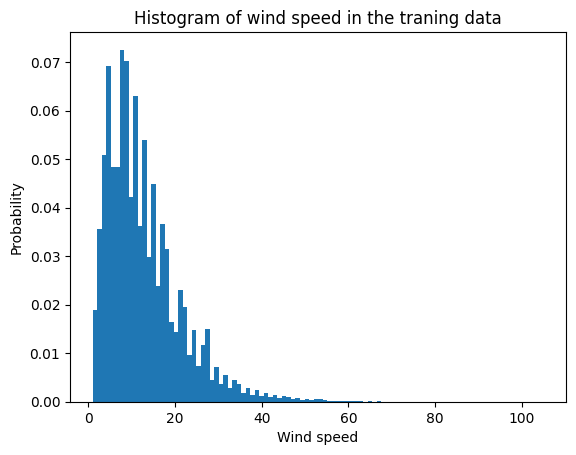

In [11]:
plt.hist(teacher_model_training_data['wind_speed'], bins=100, density=True)
plt.title("Histogram of wind speed in the traning data")
plt.ylabel("Probability")
plt.xlabel("Wind speed")

In [12]:
def generate_folds(x, y):
    split_train_x, split_val_x, split_train_y, split_val_y = train_test_split(x, y, test_size=0.1)
    
    return  split_train_x, split_val_x, split_train_y, split_val_y

In [13]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [14]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 10
    FCM_m = 2
    tol = 1e-5
    max_iter = 100

    
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break

    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    
    return rmse_train, rmse_validation

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.scatter(range(len(train_y)), train_y, c='blue', label='Target')
#     plt.scatter(range(len(y_hat_train)), y_hat_train, c='red', label='Predict')
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.scatter(range(len(test_y)), test_y, c='blue', label='Target')
#     plt.scatter(range(len(y_hat_test)), y_hat_test, c='red', label='Predict')
#     plt.title('Testing')
#     plt.legend()
#     plt.show()

In [15]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [16]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [17]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error']))

In [18]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1, 2, 3, 4, 5, 6]
number_of_epochs = 30

# Expeirment related parameters
number_of_folds = 10
# General hyperparameter
max_threshold_distance = 200 #km
min_threshold_distance = 0 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x = []
        train_y = []
        
        for station in teacher_model_training_data['name'].unique():
            features, target = Data_utils.generate_data(
                teacher_model_training_data, 
                station, 
                hyperparameter_value, 
                max_threshold_distance, 
                min_threshold_distance
            )
    
            if (len(features)!=0) & (len(target)!=0):
                np_features = np.array(features)
                np_target = np.array(target)

                train_x.append(np_features)
                train_y.append(np_target)
                
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x =  np.array([data for sublist in train_x for data in sublist])
        flatten_y =  np.array([data for sublist in train_y for data in sublist])
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        for i in range(0, number_of_folds):            
            split_train_x, split_val_x, split_train_y, split_val_y = generate_folds(flatten_x, flatten_y)
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        
        

In [19]:
do_experiment(number_of_neighbour_stations)

linear train
6.55748932805411
linear_validation
6.551289123250116
FCM traning RMSE: 6.501240282196553
FCM val RMSE: 6.488435270749535
Epoch 1/30
17141/17141 [==============================] - 24s 1ms/step - loss: 44.6377 - root_mean_squared_error: 6.6811 - val_loss: 38.3694 - val_root_mean_squared_error: 6.1943
Epoch 2/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.9335 - root_mean_squared_error: 6.1590 - val_loss: 37.3589 - val_root_mean_squared_error: 6.1122
Epoch 3/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.3000 - root_mean_squared_error: 6.1074 - val_loss: 36.9134 - val_root_mean_squared_error: 6.0756
Epoch 4/30
17141/17141 [==============================] - 24s 1ms/step - loss: 36.9479 - root_mean_squared_error: 6.0785 - val_loss: 36.6787 - val_root_mean_squared_error: 6.0563
Epoch 5/30
17141/17141 [==============================] - 24s 1ms/step - loss: 36.6973 - root_mean_squared_error: 6.0578 - val_loss: 36.4128 - val_roo

17141/17141 [==============================] - 24s 1ms/step - loss: 33.6648 - root_mean_squared_error: 5.8021 - val_loss: 33.9357 - val_root_mean_squared_error: 5.8254
Epoch 16/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.5397 - root_mean_squared_error: 5.7913 - val_loss: 33.7647 - val_root_mean_squared_error: 5.8107
Epoch 17/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.4304 - root_mean_squared_error: 5.7819 - val_loss: 33.7516 - val_root_mean_squared_error: 5.8096
Epoch 18/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.3357 - root_mean_squared_error: 5.7737 - val_loss: 33.6258 - val_root_mean_squared_error: 5.7988
Epoch 19/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.2368 - root_mean_squared_error: 5.7651 - val_loss: 33.6239 - val_root_mean_squared_error: 5.7986
Epoch 20/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.1557 - root_mean_squared_erro

Epoch 30/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.5276 - root_mean_squared_error: 5.7033 - val_loss: 32.6273 - val_root_mean_squared_error: 5.7120
linear train
6.555637042808725
linear_validation
6.56795334148541
FCM traning RMSE: 6.498798900742817
FCM val RMSE: 6.508512728193645
Epoch 1/30
17141/17141 [==============================] - 24s 1ms/step - loss: 44.8542 - root_mean_squared_error: 6.6973 - val_loss: 38.3657 - val_root_mean_squared_error: 6.1940
Epoch 2/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.6927 - root_mean_squared_error: 6.1394 - val_loss: 37.1509 - val_root_mean_squared_error: 6.0952
Epoch 3/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.0396 - root_mean_squared_error: 6.0860 - val_loss: 36.9511 - val_root_mean_squared_error: 6.0787
Epoch 4/30
17141/17141 [==============================] - 24s 1ms/step - loss: 36.8114 - root_mean_squared_error: 6.0672 - val_loss: 36.6324 - val_ro

17141/17141 [==============================] - 24s 1ms/step - loss: 33.5714 - root_mean_squared_error: 5.7941 - val_loss: 33.8579 - val_root_mean_squared_error: 5.8188
Epoch 15/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.4833 - root_mean_squared_error: 5.7865 - val_loss: 33.7605 - val_root_mean_squared_error: 5.8104
Epoch 16/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.3874 - root_mean_squared_error: 5.7782 - val_loss: 33.6314 - val_root_mean_squared_error: 5.7993
Epoch 17/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.2928 - root_mean_squared_error: 5.7700 - val_loss: 33.7100 - val_root_mean_squared_error: 5.8060
Epoch 18/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.2051 - root_mean_squared_error: 5.7624 - val_loss: 33.4313 - val_root_mean_squared_error: 5.7820
Epoch 19/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.1284 - root_mean_squared_erro

Epoch 29/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.3822 - root_mean_squared_error: 5.6905 - val_loss: 32.8525 - val_root_mean_squared_error: 5.7317
Epoch 30/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.3630 - root_mean_squared_error: 5.6889 - val_loss: 32.9581 - val_root_mean_squared_error: 5.7409
linear train
6.557511821987412
linear_validation
6.551044174727388
FCM traning RMSE: 6.5010821927048505
FCM val RMSE: 6.489674476505152
Epoch 1/30
17141/17141 [==============================] - 24s 1ms/step - loss: 44.8524 - root_mean_squared_error: 6.6972 - val_loss: 38.3980 - val_root_mean_squared_error: 6.1966
Epoch 2/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.8637 - root_mean_squared_error: 6.1533 - val_loss: 37.3386 - val_root_mean_squared_error: 6.1105
Epoch 3/30
17141/17141 [==============================] - 24s 1ms/step - loss: 37.2034 - root_mean_squared_error: 6.0995 - val_loss: 36.9029 - val

17141/17141 [==============================] - 24s 1ms/step - loss: 35.1838 - root_mean_squared_error: 5.9316 - val_loss: 34.6924 - val_root_mean_squared_error: 5.8900
Epoch 14/30
17141/17141 [==============================] - 24s 1ms/step - loss: 34.8621 - root_mean_squared_error: 5.9044 - val_loss: 34.4667 - val_root_mean_squared_error: 5.8708
Epoch 15/30
17141/17141 [==============================] - 24s 1ms/step - loss: 34.4426 - root_mean_squared_error: 5.8688 - val_loss: 33.9779 - val_root_mean_squared_error: 5.8291
Epoch 16/30
17141/17141 [==============================] - 24s 1ms/step - loss: 34.1030 - root_mean_squared_error: 5.8398 - val_loss: 33.6694 - val_root_mean_squared_error: 5.8025
Epoch 17/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.8723 - root_mean_squared_error: 5.8200 - val_loss: 33.4801 - val_root_mean_squared_error: 5.7862
Epoch 18/30
17141/17141 [==============================] - 24s 1ms/step - loss: 33.7320 - root_mean_squared_erro

Epoch 28/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.7580 - root_mean_squared_error: 5.7235 - val_loss: 32.7199 - val_root_mean_squared_error: 5.7201
Epoch 29/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.7045 - root_mean_squared_error: 5.7188 - val_loss: 32.8876 - val_root_mean_squared_error: 5.7348
Epoch 30/30
17141/17141 [==============================] - 24s 1ms/step - loss: 32.6549 - root_mean_squared_error: 5.7144 - val_loss: 32.6976 - val_root_mean_squared_error: 5.7182
linear train
6.560157324240962
linear_validation
6.527183433013983
FCM traning RMSE: 6.503183141245886
FCM val RMSE: 6.469621378331931
Epoch 1/30
17141/17141 [==============================] - 25s 1ms/step - loss: 44.8118 - root_mean_squared_error: 6.6942 - val_loss: 38.2317 - val_root_mean_squared_error: 6.1832
Epoch 2/30
17141/17141 [==============================] - 24s 1ms/step - loss: 38.0305 - root_mean_squared_error: 6.1669 - val_loss: 37.0410 - val

5183/5183 [==============================] - 7s 1ms/step - loss: 41.3414 - root_mean_squared_error: 6.4297 - val_loss: 41.3174 - val_root_mean_squared_error: 6.4279
Epoch 10/30
5183/5183 [==============================] - 7s 1ms/step - loss: 41.0979 - root_mean_squared_error: 6.4108 - val_loss: 41.0668 - val_root_mean_squared_error: 6.4083
Epoch 11/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.8607 - root_mean_squared_error: 6.3922 - val_loss: 41.0046 - val_root_mean_squared_error: 6.4035
Epoch 12/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.6768 - root_mean_squared_error: 6.3778 - val_loss: 40.7193 - val_root_mean_squared_error: 6.3812
Epoch 13/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.5151 - root_mean_squared_error: 6.3651 - val_loss: 40.6075 - val_root_mean_squared_error: 6.3724
Epoch 14/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.3775 - root_mean_squared_error: 6.3543 - val_lo

5183/5183 [==============================] - 7s 1ms/step - loss: 38.9855 - root_mean_squared_error: 6.2438 - val_loss: 39.0851 - val_root_mean_squared_error: 6.2518
Epoch 25/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.9195 - root_mean_squared_error: 6.2385 - val_loss: 39.0111 - val_root_mean_squared_error: 6.2459
Epoch 26/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.8557 - root_mean_squared_error: 6.2334 - val_loss: 39.0048 - val_root_mean_squared_error: 6.2454
Epoch 27/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.7907 - root_mean_squared_error: 6.2282 - val_loss: 39.0071 - val_root_mean_squared_error: 6.2456
Epoch 28/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.7621 - root_mean_squared_error: 6.2259 - val_loss: 38.8517 - val_root_mean_squared_error: 6.2331
Epoch 29/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.7044 - root_mean_squared_error: 6.2213 - val_lo

Epoch 9/30
5183/5183 [==============================] - 7s 1ms/step - loss: 41.1777 - root_mean_squared_error: 6.4170 - val_loss: 41.7332 - val_root_mean_squared_error: 6.4601
Epoch 10/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.8392 - root_mean_squared_error: 6.3906 - val_loss: 41.5015 - val_root_mean_squared_error: 6.4422
Epoch 11/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.5669 - root_mean_squared_error: 6.3692 - val_loss: 41.3180 - val_root_mean_squared_error: 6.4279
Epoch 12/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.3744 - root_mean_squared_error: 6.3541 - val_loss: 41.0696 - val_root_mean_squared_error: 6.4086
Epoch 13/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.1821 - root_mean_squared_error: 6.3389 - val_loss: 40.9591 - val_root_mean_squared_error: 6.3999
Epoch 14/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.0369 - root_mean_squared_error: 6.32

5183/5183 [==============================] - 7s 1ms/step - loss: 39.2881 - root_mean_squared_error: 6.2680 - val_loss: 39.4458 - val_root_mean_squared_error: 6.2806
Epoch 25/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.2056 - root_mean_squared_error: 6.2614 - val_loss: 39.2522 - val_root_mean_squared_error: 6.2652
Epoch 26/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.1701 - root_mean_squared_error: 6.2586 - val_loss: 39.2818 - val_root_mean_squared_error: 6.2675
Epoch 27/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.1092 - root_mean_squared_error: 6.2537 - val_loss: 39.2156 - val_root_mean_squared_error: 6.2622
Epoch 28/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.0578 - root_mean_squared_error: 6.2496 - val_loss: 39.2271 - val_root_mean_squared_error: 6.2632
Epoch 29/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.0272 - root_mean_squared_error: 6.2472 - val_lo

Epoch 9/30
5183/5183 [==============================] - 7s 1ms/step - loss: 41.1042 - root_mean_squared_error: 6.4113 - val_loss: 42.0988 - val_root_mean_squared_error: 6.4884
Epoch 10/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.8224 - root_mean_squared_error: 6.3892 - val_loss: 41.9483 - val_root_mean_squared_error: 6.4768
Epoch 11/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.5890 - root_mean_squared_error: 6.3710 - val_loss: 41.7261 - val_root_mean_squared_error: 6.4596
Epoch 12/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.4048 - root_mean_squared_error: 6.3565 - val_loss: 41.4815 - val_root_mean_squared_error: 6.4406
Epoch 13/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.2291 - root_mean_squared_error: 6.3426 - val_loss: 41.5197 - val_root_mean_squared_error: 6.4436
Epoch 14/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.0787 - root_mean_squared_error: 6.33

5183/5183 [==============================] - 7s 1ms/step - loss: 39.2330 - root_mean_squared_error: 6.2636 - val_loss: 39.1842 - val_root_mean_squared_error: 6.2597
Epoch 25/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.1691 - root_mean_squared_error: 6.2585 - val_loss: 39.0859 - val_root_mean_squared_error: 6.2519
Epoch 26/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.1173 - root_mean_squared_error: 6.2544 - val_loss: 39.1100 - val_root_mean_squared_error: 6.2538
Epoch 27/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.0793 - root_mean_squared_error: 6.2513 - val_loss: 39.0627 - val_root_mean_squared_error: 6.2500
Epoch 28/30
5183/5183 [==============================] - 7s 1ms/step - loss: 39.0390 - root_mean_squared_error: 6.2481 - val_loss: 39.1049 - val_root_mean_squared_error: 6.2534
Epoch 29/30
5183/5183 [==============================] - 7s 1ms/step - loss: 38.9959 - root_mean_squared_error: 6.2447 - val_lo

Epoch 9/30
5183/5183 [==============================] - 7s 1ms/step - loss: 41.0928 - root_mean_squared_error: 6.4104 - val_loss: 41.0204 - val_root_mean_squared_error: 6.4047
Epoch 10/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.8155 - root_mean_squared_error: 6.3887 - val_loss: 40.7043 - val_root_mean_squared_error: 6.3800
Epoch 11/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.5779 - root_mean_squared_error: 6.3701 - val_loss: 40.4989 - val_root_mean_squared_error: 6.3639
Epoch 12/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.4158 - root_mean_squared_error: 6.3573 - val_loss: 40.4082 - val_root_mean_squared_error: 6.3567
Epoch 13/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.2050 - root_mean_squared_error: 6.3407 - val_loss: 40.2035 - val_root_mean_squared_error: 6.3406
Epoch 14/30
5183/5183 [==============================] - 7s 1ms/step - loss: 40.0149 - root_mean_squared_error: 6.32

Epoch 21/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.5894 - root_mean_squared_error: 6.3710 - val_loss: 40.9434 - val_root_mean_squared_error: 6.3987
Epoch 22/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.4099 - root_mean_squared_error: 6.3569 - val_loss: 41.2367 - val_root_mean_squared_error: 6.4216
Epoch 23/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.2490 - root_mean_squared_error: 6.3442 - val_loss: 40.7378 - val_root_mean_squared_error: 6.3826
Epoch 24/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.1322 - root_mean_squared_error: 6.3350 - val_loss: 40.7960 - val_root_mean_squared_error: 6.3872
Epoch 25/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.9703 - root_mean_squared_error: 6.3222 - val_loss: 40.5561 - val_root_mean_squared_error: 6.3684
Epoch 26/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.8825 - root_mean_squared_error: 6.3

Epoch 6/30
2048/2048 [==============================] - 3s 1ms/step - loss: 45.0628 - root_mean_squared_error: 6.7129 - val_loss: 44.0289 - val_root_mean_squared_error: 6.6354
Epoch 7/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.4800 - root_mean_squared_error: 6.6693 - val_loss: 43.4812 - val_root_mean_squared_error: 6.5940
Epoch 8/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.0059 - root_mean_squared_error: 6.6337 - val_loss: 43.0847 - val_root_mean_squared_error: 6.5639
Epoch 9/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.6065 - root_mean_squared_error: 6.6035 - val_loss: 42.5896 - val_root_mean_squared_error: 6.5261
Epoch 10/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.2101 - root_mean_squared_error: 6.5734 - val_loss: 42.1286 - val_root_mean_squared_error: 6.4907
Epoch 11/30
2048/2048 [==============================] - 3s 1ms/step - loss: 42.8536 - root_mean_squared_error: 6.5463 

2048/2048 [==============================] - 3s 1ms/step - loss: 40.5761 - root_mean_squared_error: 6.3699 - val_loss: 39.0254 - val_root_mean_squared_error: 6.2470
Epoch 22/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.3529 - root_mean_squared_error: 6.3524 - val_loss: 38.9681 - val_root_mean_squared_error: 6.2424
Epoch 23/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.2073 - root_mean_squared_error: 6.3409 - val_loss: 38.6517 - val_root_mean_squared_error: 6.2171
Epoch 24/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.0621 - root_mean_squared_error: 6.3295 - val_loss: 38.7143 - val_root_mean_squared_error: 6.2221
Epoch 25/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.8992 - root_mean_squared_error: 6.3166 - val_loss: 38.5247 - val_root_mean_squared_error: 6.2068
Epoch 26/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.7990 - root_mean_squared_error: 6.3086 - val_lo

Epoch 6/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.8161 - root_mean_squared_error: 6.6945 - val_loss: 43.5056 - val_root_mean_squared_error: 6.5959
Epoch 7/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.1565 - root_mean_squared_error: 6.6450 - val_loss: 42.8624 - val_root_mean_squared_error: 6.5469
Epoch 8/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.6489 - root_mean_squared_error: 6.6067 - val_loss: 42.8183 - val_root_mean_squared_error: 6.5436
Epoch 9/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.2470 - root_mean_squared_error: 6.5762 - val_loss: 42.2050 - val_root_mean_squared_error: 6.4965
Epoch 10/30
2048/2048 [==============================] - 3s 1ms/step - loss: 42.9228 - root_mean_squared_error: 6.5516 - val_loss: 41.7772 - val_root_mean_squared_error: 6.4635
Epoch 11/30
2048/2048 [==============================] - 3s 1ms/step - loss: 42.5788 - root_mean_squared_error: 6.5252 

2048/2048 [==============================] - 3s 1ms/step - loss: 39.9466 - root_mean_squared_error: 6.3203 - val_loss: 39.3545 - val_root_mean_squared_error: 6.2733
Epoch 22/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.7466 - root_mean_squared_error: 6.3045 - val_loss: 39.4043 - val_root_mean_squared_error: 6.2773
Epoch 23/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.6365 - root_mean_squared_error: 6.2958 - val_loss: 39.0896 - val_root_mean_squared_error: 6.2522
Epoch 24/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.5485 - root_mean_squared_error: 6.2888 - val_loss: 39.2033 - val_root_mean_squared_error: 6.2613
Epoch 25/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.4376 - root_mean_squared_error: 6.2799 - val_loss: 38.9136 - val_root_mean_squared_error: 6.2381
Epoch 26/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.3692 - root_mean_squared_error: 6.2745 - val_lo

Epoch 6/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.8709 - root_mean_squared_error: 6.6986 - val_loss: 45.0233 - val_root_mean_squared_error: 6.7099
Epoch 7/30
2048/2048 [==============================] - 3s 1ms/step - loss: 44.2311 - root_mean_squared_error: 6.6506 - val_loss: 44.2521 - val_root_mean_squared_error: 6.6522
Epoch 8/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.6377 - root_mean_squared_error: 6.6059 - val_loss: 43.7772 - val_root_mean_squared_error: 6.6164
Epoch 9/30
2048/2048 [==============================] - 3s 1ms/step - loss: 43.1353 - root_mean_squared_error: 6.5677 - val_loss: 43.3881 - val_root_mean_squared_error: 6.5870
Epoch 10/30
2048/2048 [==============================] - 3s 1ms/step - loss: 42.6972 - root_mean_squared_error: 6.5343 - val_loss: 43.1389 - val_root_mean_squared_error: 6.5680
Epoch 11/30
2048/2048 [==============================] - 3s 1ms/step - loss: 42.3263 - root_mean_squared_error: 6.5059 

2048/2048 [==============================] - 3s 1ms/step - loss: 40.4884 - root_mean_squared_error: 6.3631 - val_loss: 41.3498 - val_root_mean_squared_error: 6.4304
Epoch 22/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.3796 - root_mean_squared_error: 6.3545 - val_loss: 41.2409 - val_root_mean_squared_error: 6.4219
Epoch 23/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.2383 - root_mean_squared_error: 6.3434 - val_loss: 41.1181 - val_root_mean_squared_error: 6.4123
Epoch 24/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.0958 - root_mean_squared_error: 6.3321 - val_loss: 41.0281 - val_root_mean_squared_error: 6.4053
Epoch 25/30
2048/2048 [==============================] - 3s 1ms/step - loss: 40.0224 - root_mean_squared_error: 6.3263 - val_loss: 40.9353 - val_root_mean_squared_error: 6.3981
Epoch 26/30
2048/2048 [==============================] - 3s 1ms/step - loss: 39.9203 - root_mean_squared_error: 6.3183 - val_lo

857/857 [==============================] - 1s 1ms/step - loss: 55.4198 - root_mean_squared_error: 7.4444 - val_loss: 52.3190 - val_root_mean_squared_error: 7.2332
Epoch 3/30
857/857 [==============================] - 1s 1ms/step - loss: 53.0305 - root_mean_squared_error: 7.2822 - val_loss: 50.7897 - val_root_mean_squared_error: 7.1267
Epoch 4/30
857/857 [==============================] - 1s 1ms/step - loss: 51.4420 - root_mean_squared_error: 7.1723 - val_loss: 49.9987 - val_root_mean_squared_error: 7.0710
Epoch 5/30
857/857 [==============================] - 1s 1ms/step - loss: 50.1947 - root_mean_squared_error: 7.0848 - val_loss: 48.9634 - val_root_mean_squared_error: 6.9974
Epoch 6/30
857/857 [==============================] - 1s 1ms/step - loss: 49.2038 - root_mean_squared_error: 7.0145 - val_loss: 48.4800 - val_root_mean_squared_error: 6.9628
Epoch 7/30
857/857 [==============================] - 1s 1ms/step - loss: 48.4881 - root_mean_squared_error: 6.9633 - val_loss: 48.0883 - val

857/857 [==============================] - 1s 1ms/step - loss: 43.7001 - root_mean_squared_error: 6.6106 - val_loss: 47.8103 - val_root_mean_squared_error: 6.9145
Epoch 19/30
857/857 [==============================] - 1s 1ms/step - loss: 43.4348 - root_mean_squared_error: 6.5905 - val_loss: 47.3819 - val_root_mean_squared_error: 6.8835
Epoch 20/30
857/857 [==============================] - 1s 1ms/step - loss: 43.2391 - root_mean_squared_error: 6.5756 - val_loss: 47.3054 - val_root_mean_squared_error: 6.8779
Epoch 21/30
857/857 [==============================] - 1s 1ms/step - loss: 43.0201 - root_mean_squared_error: 6.5590 - val_loss: 47.1215 - val_root_mean_squared_error: 6.8645
Epoch 22/30
857/857 [==============================] - 1s 1ms/step - loss: 42.8418 - root_mean_squared_error: 6.5454 - val_loss: 47.2137 - val_root_mean_squared_error: 6.8712
Epoch 23/30
857/857 [==============================] - 1s 1ms/step - loss: 42.6539 - root_mean_squared_error: 6.5310 - val_loss: 47.0183 

857/857 [==============================] - 1s 1ms/step - loss: 52.6414 - root_mean_squared_error: 7.2554 - val_loss: 54.7672 - val_root_mean_squared_error: 7.4005
Epoch 4/30
857/857 [==============================] - 1s 1ms/step - loss: 51.0757 - root_mean_squared_error: 7.1467 - val_loss: 53.5300 - val_root_mean_squared_error: 7.3164
Epoch 5/30
857/857 [==============================] - 1s 1ms/step - loss: 49.9946 - root_mean_squared_error: 7.0707 - val_loss: 52.1954 - val_root_mean_squared_error: 7.2246
Epoch 6/30
857/857 [==============================] - 1s 1ms/step - loss: 49.3105 - root_mean_squared_error: 7.0221 - val_loss: 51.4053 - val_root_mean_squared_error: 7.1697
Epoch 7/30
857/857 [==============================] - 1s 1ms/step - loss: 48.7311 - root_mean_squared_error: 6.9808 - val_loss: 51.2109 - val_root_mean_squared_error: 7.1562
Epoch 8/30
857/857 [==============================] - 1s 1ms/step - loss: 48.2399 - root_mean_squared_error: 6.9455 - val_loss: 50.7978 - val

857/857 [==============================] - 1s 1ms/step - loss: 44.2184 - root_mean_squared_error: 6.6497 - val_loss: 45.1373 - val_root_mean_squared_error: 6.7184
Epoch 20/30
857/857 [==============================] - 1s 1ms/step - loss: 43.9587 - root_mean_squared_error: 6.6301 - val_loss: 44.8189 - val_root_mean_squared_error: 6.6947
Epoch 21/30
857/857 [==============================] - 1s 2ms/step - loss: 43.7359 - root_mean_squared_error: 6.6133 - val_loss: 45.0727 - val_root_mean_squared_error: 6.7136
Epoch 22/30
857/857 [==============================] - 1s 1ms/step - loss: 43.5012 - root_mean_squared_error: 6.5955 - val_loss: 44.1528 - val_root_mean_squared_error: 6.6448
Epoch 23/30
857/857 [==============================] - 1s 1ms/step - loss: 43.3087 - root_mean_squared_error: 6.5809 - val_loss: 43.9322 - val_root_mean_squared_error: 6.6281
Epoch 24/30
857/857 [==============================] - 1s 1ms/step - loss: 43.0368 - root_mean_squared_error: 6.5602 - val_loss: 44.3917 

857/857 [==============================] - 1s 1ms/step - loss: 51.6024 - root_mean_squared_error: 7.1835 - val_loss: 47.4345 - val_root_mean_squared_error: 6.8873
Epoch 5/30
857/857 [==============================] - 1s 1ms/step - loss: 50.4160 - root_mean_squared_error: 7.1004 - val_loss: 46.6034 - val_root_mean_squared_error: 6.8267
Epoch 6/30
857/857 [==============================] - 1s 1ms/step - loss: 49.6208 - root_mean_squared_error: 7.0442 - val_loss: 45.7966 - val_root_mean_squared_error: 6.7673
Epoch 7/30
857/857 [==============================] - 1s 1ms/step - loss: 48.8889 - root_mean_squared_error: 6.9921 - val_loss: 45.4439 - val_root_mean_squared_error: 6.7412
Epoch 8/30
857/857 [==============================] - 1s 1ms/step - loss: 48.3552 - root_mean_squared_error: 6.9538 - val_loss: 45.4403 - val_root_mean_squared_error: 6.7409
Epoch 9/30
857/857 [==============================] - 1s 1ms/step - loss: 47.8388 - root_mean_squared_error: 6.9166 - val_loss: 45.0633 - val

857/857 [==============================] - 1s 2ms/step - loss: 44.0530 - root_mean_squared_error: 6.6372 - val_loss: 43.6624 - val_root_mean_squared_error: 6.6078
Epoch 21/30
857/857 [==============================] - 1s 1ms/step - loss: 43.8338 - root_mean_squared_error: 6.6207 - val_loss: 43.5624 - val_root_mean_squared_error: 6.6002
Epoch 22/30
857/857 [==============================] - 1s 1ms/step - loss: 43.6568 - root_mean_squared_error: 6.6073 - val_loss: 43.5694 - val_root_mean_squared_error: 6.6007
Epoch 23/30
857/857 [==============================] - 1s 1ms/step - loss: 43.4492 - root_mean_squared_error: 6.5916 - val_loss: 43.2601 - val_root_mean_squared_error: 6.5772
Epoch 24/30
857/857 [==============================] - 1s 1ms/step - loss: 43.2478 - root_mean_squared_error: 6.5763 - val_loss: 43.0911 - val_root_mean_squared_error: 6.5644
Epoch 25/30
857/857 [==============================] - 1s 1ms/step - loss: 43.0137 - root_mean_squared_error: 6.5585 - val_loss: 43.0614 

305/305 [==============================] - 1s 2ms/step - loss: 296.0285 - root_mean_squared_error: 17.2055 - val_loss: 236.6820 - val_root_mean_squared_error: 15.3845
Epoch 2/30
305/305 [==============================] - 0s 1ms/step - loss: 143.6067 - root_mean_squared_error: 11.9836 - val_loss: 89.3903 - val_root_mean_squared_error: 9.4546
Epoch 3/30
305/305 [==============================] - 0s 1ms/step - loss: 67.7108 - root_mean_squared_error: 8.2287 - val_loss: 64.6426 - val_root_mean_squared_error: 8.0401
Epoch 4/30
305/305 [==============================] - 0s 2ms/step - loss: 59.5144 - root_mean_squared_error: 7.7146 - val_loss: 61.4079 - val_root_mean_squared_error: 7.8363
Epoch 5/30
305/305 [==============================] - 0s 2ms/step - loss: 57.6340 - root_mean_squared_error: 7.5917 - val_loss: 59.4884 - val_root_mean_squared_error: 7.7129
Epoch 6/30
305/305 [==============================] - 0s 2ms/step - loss: 56.3209 - root_mean_squared_error: 7.5047 - val_loss: 58.6190

305/305 [==============================] - 0s 1ms/step - loss: 50.0276 - root_mean_squared_error: 7.0730 - val_loss: 48.5859 - val_root_mean_squared_error: 6.9704
Epoch 18/30
305/305 [==============================] - 0s 1ms/step - loss: 49.6657 - root_mean_squared_error: 7.0474 - val_loss: 48.4454 - val_root_mean_squared_error: 6.9603
Epoch 19/30
305/305 [==============================] - 0s 1ms/step - loss: 49.3620 - root_mean_squared_error: 7.0258 - val_loss: 48.5160 - val_root_mean_squared_error: 6.9653
Epoch 20/30
305/305 [==============================] - 0s 1ms/step - loss: 49.0700 - root_mean_squared_error: 7.0050 - val_loss: 48.3965 - val_root_mean_squared_error: 6.9568
Epoch 21/30
305/305 [==============================] - 0s 1ms/step - loss: 48.8775 - root_mean_squared_error: 6.9912 - val_loss: 48.0664 - val_root_mean_squared_error: 6.9330
Epoch 22/30
305/305 [==============================] - 0s 1ms/step - loss: 48.5714 - root_mean_squared_error: 6.9693 - val_loss: 48.3321 

305/305 [==============================] - 0s 1ms/step - loss: 143.3866 - root_mean_squared_error: 11.9744 - val_loss: 88.1761 - val_root_mean_squared_error: 9.3902
Epoch 3/30
305/305 [==============================] - 0s 1ms/step - loss: 66.3673 - root_mean_squared_error: 8.1466 - val_loss: 62.4327 - val_root_mean_squared_error: 7.9014
Epoch 4/30
305/305 [==============================] - 0s 1ms/step - loss: 58.3699 - root_mean_squared_error: 7.6400 - val_loss: 59.7192 - val_root_mean_squared_error: 7.7278
Epoch 5/30
305/305 [==============================] - 0s 1ms/step - loss: 56.7895 - root_mean_squared_error: 7.5359 - val_loss: 58.2822 - val_root_mean_squared_error: 7.6343
Epoch 6/30
305/305 [==============================] - 0s 1ms/step - loss: 55.6182 - root_mean_squared_error: 7.4578 - val_loss: 57.2111 - val_root_mean_squared_error: 7.5638
Epoch 7/30
305/305 [==============================] - 0s 1ms/step - loss: 54.7372 - root_mean_squared_error: 7.3985 - val_loss: 56.4085 - v

305/305 [==============================] - 0s 1ms/step - loss: 48.4086 - root_mean_squared_error: 6.9576 - val_loss: 48.3560 - val_root_mean_squared_error: 6.9538
Epoch 19/30
305/305 [==============================] - 0s 1ms/step - loss: 48.0054 - root_mean_squared_error: 6.9286 - val_loss: 48.4746 - val_root_mean_squared_error: 6.9624
Epoch 20/30
305/305 [==============================] - 0s 1ms/step - loss: 47.7080 - root_mean_squared_error: 6.9071 - val_loss: 48.4391 - val_root_mean_squared_error: 6.9598
Epoch 21/30
305/305 [==============================] - 0s 1ms/step - loss: 47.3522 - root_mean_squared_error: 6.8813 - val_loss: 48.7960 - val_root_mean_squared_error: 6.9854
Epoch 22/30
305/305 [==============================] - 0s 2ms/step - loss: 47.0782 - root_mean_squared_error: 6.8614 - val_loss: 48.2633 - val_root_mean_squared_error: 6.9472
Epoch 23/30
305/305 [==============================] - 0s 2ms/step - loss: 46.8632 - root_mean_squared_error: 6.8457 - val_loss: 48.4806 

305/305 [==============================] - 0s 1ms/step - loss: 67.4827 - root_mean_squared_error: 8.2148 - val_loss: 56.3633 - val_root_mean_squared_error: 7.5075
Epoch 4/30
305/305 [==============================] - 0s 1ms/step - loss: 59.8202 - root_mean_squared_error: 7.7344 - val_loss: 54.8486 - val_root_mean_squared_error: 7.4060
Epoch 5/30
305/305 [==============================] - 0s 1ms/step - loss: 58.0826 - root_mean_squared_error: 7.6212 - val_loss: 53.7576 - val_root_mean_squared_error: 7.3320
Epoch 6/30
305/305 [==============================] - 0s 1ms/step - loss: 56.7141 - root_mean_squared_error: 7.5309 - val_loss: 52.9546 - val_root_mean_squared_error: 7.2770
Epoch 7/30
305/305 [==============================] - 0s 1ms/step - loss: 55.6081 - root_mean_squared_error: 7.4571 - val_loss: 52.2152 - val_root_mean_squared_error: 7.2260
Epoch 8/30
305/305 [==============================] - 0s 1ms/step - loss: 54.8253 - root_mean_squared_error: 7.4044 - val_loss: 52.0907 - val

305/305 [==============================] - 0s 1ms/step - loss: 48.3902 - root_mean_squared_error: 6.9563 - val_loss: 50.7007 - val_root_mean_squared_error: 7.1204
Epoch 20/30
305/305 [==============================] - 0s 1ms/step - loss: 48.0467 - root_mean_squared_error: 6.9316 - val_loss: 50.6904 - val_root_mean_squared_error: 7.1197
Epoch 21/30
305/305 [==============================] - 0s 1ms/step - loss: 47.8158 - root_mean_squared_error: 6.9149 - val_loss: 50.4514 - val_root_mean_squared_error: 7.1029
Epoch 22/30
305/305 [==============================] - 0s 1ms/step - loss: 47.5842 - root_mean_squared_error: 6.8981 - val_loss: 51.1587 - val_root_mean_squared_error: 7.1525
Epoch 23/30
305/305 [==============================] - 0s 1ms/step - loss: 47.3446 - root_mean_squared_error: 6.8807 - val_loss: 50.2428 - val_root_mean_squared_error: 7.0882
Epoch 24/30
305/305 [==============================] - 0s 1ms/step - loss: 47.0575 - root_mean_squared_error: 6.8598 - val_loss: 50.2220 

305/305 [==============================] - 0s 1ms/step - loss: 59.8295 - root_mean_squared_error: 7.7350 - val_loss: 55.8643 - val_root_mean_squared_error: 7.4742
Epoch 5/30
305/305 [==============================] - 0s 1ms/step - loss: 57.9445 - root_mean_squared_error: 7.6121 - val_loss: 54.5357 - val_root_mean_squared_error: 7.3848
Epoch 6/30
305/305 [==============================] - 0s 1ms/step - loss: 56.5592 - root_mean_squared_error: 7.5206 - val_loss: 53.4293 - val_root_mean_squared_error: 7.3095
Epoch 7/30
305/305 [==============================] - 0s 1ms/step - loss: 55.5442 - root_mean_squared_error: 7.4528 - val_loss: 53.2482 - val_root_mean_squared_error: 7.2971
Epoch 8/30
305/305 [==============================] - 0s 1ms/step - loss: 54.5764 - root_mean_squared_error: 7.3876 - val_loss: 52.5591 - val_root_mean_squared_error: 7.2498
Epoch 9/30
305/305 [==============================] - 0s 2ms/step - loss: 53.7676 - root_mean_squared_error: 7.3326 - val_loss: 52.0510 - val

119/119 [==============================] - 0s 2ms/step - loss: 58.2452 - root_mean_squared_error: 7.6319 - val_loss: 57.1779 - val_root_mean_squared_error: 7.5616
Epoch 16/30
119/119 [==============================] - 0s 2ms/step - loss: 57.7308 - root_mean_squared_error: 7.5981 - val_loss: 56.9273 - val_root_mean_squared_error: 7.5450
Epoch 17/30
119/119 [==============================] - 0s 2ms/step - loss: 57.1396 - root_mean_squared_error: 7.5591 - val_loss: 56.4663 - val_root_mean_squared_error: 7.5144
Epoch 18/30
119/119 [==============================] - 0s 2ms/step - loss: 56.6636 - root_mean_squared_error: 7.5275 - val_loss: 55.8909 - val_root_mean_squared_error: 7.4760
Epoch 19/30
119/119 [==============================] - 0s 2ms/step - loss: 56.0244 - root_mean_squared_error: 7.4849 - val_loss: 55.7416 - val_root_mean_squared_error: 7.4660
Epoch 20/30
119/119 [==============================] - 0s 2ms/step - loss: 55.5805 - root_mean_squared_error: 7.4552 - val_loss: 55.1836 

FCM traning RMSE: 7.292093648777986
FCM val RMSE: 7.2783205439686185
Epoch 1/30
119/119 [==============================] - 0s 2ms/step - loss: 333.6165 - root_mean_squared_error: 18.2652 - val_loss: 295.2710 - val_root_mean_squared_error: 17.1835
Epoch 2/30
119/119 [==============================] - 0s 2ms/step - loss: 293.2430 - root_mean_squared_error: 17.1243 - val_loss: 251.7994 - val_root_mean_squared_error: 15.8682
Epoch 3/30
119/119 [==============================] - 0s 2ms/step - loss: 238.5233 - root_mean_squared_error: 15.4442 - val_loss: 191.7518 - val_root_mean_squared_error: 13.8474
Epoch 4/30
119/119 [==============================] - 0s 2ms/step - loss: 169.9124 - root_mean_squared_error: 13.0350 - val_loss: 126.4924 - val_root_mean_squared_error: 11.2469
Epoch 5/30
119/119 [==============================] - 0s 2ms/step - loss: 112.7767 - root_mean_squared_error: 10.6196 - val_loss: 85.2236 - val_root_mean_squared_error: 9.2317
Epoch 6/30
119/119 [=======================

119/119 [==============================] - 0s 2ms/step - loss: 56.2696 - root_mean_squared_error: 7.5013 - val_loss: 58.3498 - val_root_mean_squared_error: 7.6387
Epoch 17/30
119/119 [==============================] - 0s 2ms/step - loss: 55.5797 - root_mean_squared_error: 7.4552 - val_loss: 57.9506 - val_root_mean_squared_error: 7.6125
Epoch 18/30
119/119 [==============================] - 0s 2ms/step - loss: 55.0590 - root_mean_squared_error: 7.4202 - val_loss: 57.6557 - val_root_mean_squared_error: 7.5931
Epoch 19/30
119/119 [==============================] - 0s 2ms/step - loss: 54.5198 - root_mean_squared_error: 7.3838 - val_loss: 57.2128 - val_root_mean_squared_error: 7.5639
Epoch 20/30
119/119 [==============================] - 0s 2ms/step - loss: 54.0938 - root_mean_squared_error: 7.3548 - val_loss: 56.7368 - val_root_mean_squared_error: 7.5324
Epoch 21/30
119/119 [==============================] - 0s 2ms/step - loss: 53.6781 - root_mean_squared_error: 7.3265 - val_loss: 56.8502 

119/119 [==============================] - 0s 2ms/step - loss: 321.7717 - root_mean_squared_error: 17.9380 - val_loss: 304.5804 - val_root_mean_squared_error: 17.4522
Epoch 2/30
119/119 [==============================] - 0s 2ms/step - loss: 276.0811 - root_mean_squared_error: 16.6157 - val_loss: 256.4921 - val_root_mean_squared_error: 16.0154
Epoch 3/30
119/119 [==============================] - 0s 2ms/step - loss: 221.6260 - root_mean_squared_error: 14.8871 - val_loss: 195.9419 - val_root_mean_squared_error: 13.9979
Epoch 4/30
119/119 [==============================] - 0s 2ms/step - loss: 158.7360 - root_mean_squared_error: 12.5990 - val_loss: 135.9403 - val_root_mean_squared_error: 11.6593
Epoch 5/30
119/119 [==============================] - 0s 2ms/step - loss: 106.7127 - root_mean_squared_error: 10.3302 - val_loss: 98.7236 - val_root_mean_squared_error: 9.9360
Epoch 6/30
119/119 [==============================] - 0s 2ms/step - loss: 78.4370 - root_mean_squared_error: 8.8565 - val_l

Epoch 17/30
119/119 [==============================] - 0s 2ms/step - loss: 56.3092 - root_mean_squared_error: 7.5039 - val_loss: 56.8754 - val_root_mean_squared_error: 7.5416
Epoch 18/30
119/119 [==============================] - 0s 2ms/step - loss: 55.6559 - root_mean_squared_error: 7.4603 - val_loss: 56.6921 - val_root_mean_squared_error: 7.5294
Epoch 19/30
119/119 [==============================] - 0s 2ms/step - loss: 55.1728 - root_mean_squared_error: 7.4278 - val_loss: 55.7905 - val_root_mean_squared_error: 7.4693
Epoch 20/30
119/119 [==============================] - 0s 2ms/step - loss: 54.6910 - root_mean_squared_error: 7.3953 - val_loss: 56.2627 - val_root_mean_squared_error: 7.5008
Epoch 21/30
119/119 [==============================] - 0s 2ms/step - loss: 54.1297 - root_mean_squared_error: 7.3573 - val_loss: 56.1083 - val_root_mean_squared_error: 7.4905
Epoch 22/30
119/119 [==============================] - 0s 2ms/step - loss: 53.6412 - root_mean_squared_error: 7.3240 - val_lo

119/119 [==============================] - 0s 2ms/step - loss: 280.0556 - root_mean_squared_error: 16.7349 - val_loss: 256.9549 - val_root_mean_squared_error: 16.0298
Epoch 3/30
119/119 [==============================] - 0s 2ms/step - loss: 223.3092 - root_mean_squared_error: 14.9435 - val_loss: 193.6092 - val_root_mean_squared_error: 13.9144
Epoch 4/30
119/119 [==============================] - 0s 2ms/step - loss: 157.0841 - root_mean_squared_error: 12.5333 - val_loss: 132.0904 - val_root_mean_squared_error: 11.4931
Epoch 5/30
119/119 [==============================] - 0s 2ms/step - loss: 105.0456 - root_mean_squared_error: 10.2492 - val_loss: 93.1028 - val_root_mean_squared_error: 9.6490
Epoch 6/30
119/119 [==============================] - 0s 2ms/step - loss: 77.6375 - root_mean_squared_error: 8.8112 - val_loss: 74.6103 - val_root_mean_squared_error: 8.6377
Epoch 7/30
119/119 [==============================] - 0s 2ms/step - loss: 66.5362 - root_mean_squared_error: 8.1570 - val_loss:

119/119 [==============================] - 0s 2ms/step - loss: 55.7976 - root_mean_squared_error: 7.4698 - val_loss: 51.1133 - val_root_mean_squared_error: 7.1494
Epoch 19/30
119/119 [==============================] - 0s 2ms/step - loss: 55.2803 - root_mean_squared_error: 7.4351 - val_loss: 50.8591 - val_root_mean_squared_error: 7.1316
Epoch 20/30
119/119 [==============================] - 0s 2ms/step - loss: 54.6718 - root_mean_squared_error: 7.3940 - val_loss: 51.0373 - val_root_mean_squared_error: 7.1440
Epoch 21/30
119/119 [==============================] - 0s 2ms/step - loss: 54.2377 - root_mean_squared_error: 7.3646 - val_loss: 50.1929 - val_root_mean_squared_error: 7.0847
Epoch 22/30
119/119 [==============================] - 0s 2ms/step - loss: 53.8789 - root_mean_squared_error: 7.3402 - val_loss: 49.9091 - val_root_mean_squared_error: 7.0646
Epoch 23/30
119/119 [==============================] - 0s 2ms/step - loss: 53.2445 - root_mean_squared_error: 7.2969 - val_loss: 50.2948 

In [33]:
training_results

[[{'linear_train': 6.55748932805411},
  {'fcm_train': 6.501240282196553},
  {'nn_train': 5.8762811660766605},
  {'linear_train': 6.555570224876772},
  {'fcm_train': 6.498570784160789},
  {'nn_train': 5.877720975875855},
  {'linear_train': 6.556543401183905},
  {'fcm_train': 6.49915551261766},
  {'nn_train': 5.889944696426392},
  {'linear_train': 6.555637042808725},
  {'fcm_train': 6.498798900742817},
  {'nn_train': 5.867303737004598},
  {'linear_train': 6.55294235135298},
  {'fcm_train': 6.495713884143013},
  {'nn_train': 5.857368199030558},
  {'linear_train': 6.550557594134464},
  {'fcm_train': 6.49328461939698},
  {'nn_train': 5.863737440109253},
  {'linear_train': 6.557511821987412},
  {'fcm_train': 6.5010821927048505},
  {'nn_train': 5.8787915229797365},
  {'linear_train': 6.560084752860671},
  {'fcm_train': 6.503085432936813},
  {'nn_train': 5.916162538528442},
  {'linear_train': 6.55448969554493},
  {'fcm_train': 6.497124331254158},
  {'nn_train': 5.9057539939880375},
  {'linear_

In [36]:
validation_results

[[{'linear_val': 6.551289123250116},
  {'fcm_val': 6.488435270749535},
  {'nn_val': 5.845998112360636},
  {'linear_val': 6.56856089065102},
  {'fcm_val': 6.510268165251559},
  {'nn_val': 5.880875953038534},
  {'linear_val': 6.5597914172550595},
  {'fcm_val': 6.503464140354023},
  {'nn_val': 5.877844587961833},
  {'linear_val': 6.56795334148541},
  {'fcm_val': 6.508512728193645},
  {'nn_val': 5.85199933052063},
  {'linear_val': 6.592095583582612},
  {'fcm_val': 6.53660350184622},
  {'nn_val': 5.865898895263672},
  {'linear_val': 6.613484132246796},
  {'fcm_val': 6.559270149009552},
  {'nn_val': 5.895499912897746},
  {'linear_val': 6.551044174727388},
  {'fcm_val': 6.489674476505152},
  {'nn_val': 5.861618455251058},
  {'linear_val': 6.527813380852533},
  {'fcm_val': 6.469632845585229},
  {'nn_val': 5.870512342453003},
  {'linear_val': 6.578249465958682},
  {'fcm_val': 6.523869851878913},
  {'nn_val': 5.901943095525106},
  {'linear_val': 6.527183433013983},
  {'fcm_val': 6.46962137833193

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for training dataset')

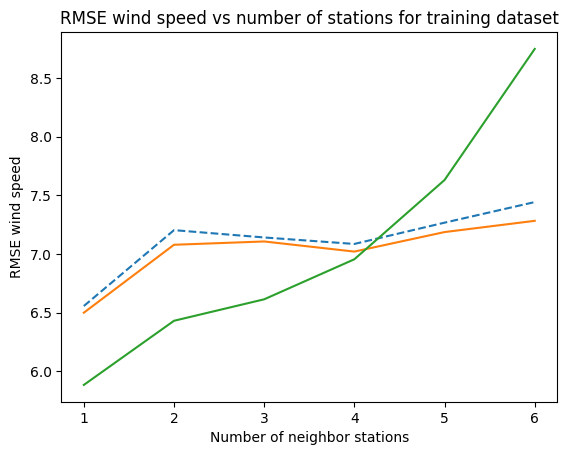

In [37]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = number_of_neighbour_stations
for exp in training_results:
    li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

plt.plot(x_axis, li_train_plot, '--')
plt.plot(x_axis, fcm_train_plot)
plt.plot(x_axis, nn_train_plot)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for training dataset')

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for validation dataset')

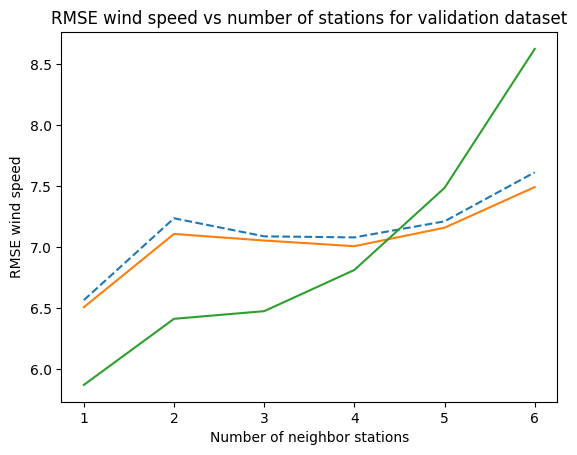

In [32]:

li_val_plot = []
fcm_val_plot = []
nn_val_plot = []
x_axis = number_of_neighbour_stations
for exp in validation_results:
    li_val_plot.append(np.mean([d['linear_val'] for d in exp if 'linear_val' in d]))
    fcm_val_plot.append(np.mean([d['fcm_val'] for d in exp if 'fcm_val' in d]))
    nn_val_plot.append(np.mean([d['nn_val'] for d in exp if 'nn_val' in d]))

plt.plot(x_axis, li_val_plot, '--')
plt.plot(x_axis, fcm_val_plot)
plt.plot(x_axis, nn_val_plot)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for validation dataset')

Text(0.5, 1.0, 'Training and validation MSE for neural network model')

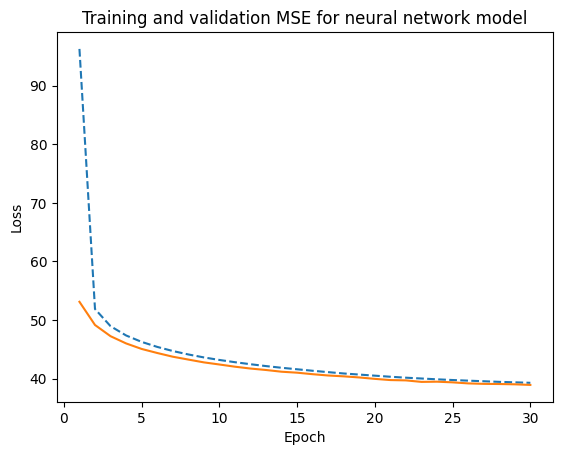

In [55]:
nn_histories

nn_val_plot = []
nn_train_plot = []
x_axis = range(1, number_of_epochs + 1)

exp = nn_histories[2]

nn_train_plot = [d['loss'] for d in exp if 'loss' in d]
nn_val_plot = [d['val_loss'] for d in exp if 'val_loss' in d]

plt.plot(x_axis, np.mean(nn_train_plot, axis=0), '--')
plt.plot(x_axis, np.mean(nn_val_plot, axis=0))
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(30, 60)
plt.title('Training and validation MSE for neural network model')